In [687]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import itertools

import os

pd.set_option('display.max_rows', 100)

In [1544]:
# directory settings
data_dir = os.path.join(os.getcwd(), "paj")
data_fns = os.listdir(data_dir)
data_keys = ['gram', 'cyp']
proper = {
    'gramwet': "Graminoids-Wet",
    'gramdry': "Graminoids-Dry",
    'cypwet': "Cypress-Wet",
    'cypdry': "Cypress-Dry",
}

In [714]:
# read in data
paj_fns = [fn for fn in data_fns if ".paj" in fn]
g = {}
for fn in paj_fns:
    key = fn.split(".paj")[0]
    g[key] = nx.read_pajek(os.path.join(data_dir, fn))

In [715]:
# load in estimated trophic levels
trophic_level_bins = 5
coefs_fns = [fn for fn in data_fns if "coefs" in fn]
coefs = {}
for fn in coefs_fns:
    key = fn.split(".")[0].split("coefs_")[-1]
    coefs[key] = pd.read_csv(os.path.join(data_dir, fn), encoding='cp1252')
    coefs[key]['Compartment'] = coefs[key]['Compartment'].str.lower()
    # bin estimated trophic levels into equal length bins
    coefs[key]['trophic_level_bin'] = pd.qcut(
        coefs[key]['ETL'],
        q=trophic_level_bins,
        labels=np.arange(0, trophic_level_bins))

In [716]:
# set trophic level attributes to nodes
for key in data_keys:
    g_k = [k for k in g.keys() if k.startswith(key)]
    attrs = coefs[key].set_index("Compartment").to_dict(orient='index')
    for k in g_k:
        for cmp in attrs:
            assert cmp in g[k].nodes, f"coefs from '{key}' not found in graph '{k}' for cmp: {cmp}"
        nx.set_node_attributes(g[k], attrs)

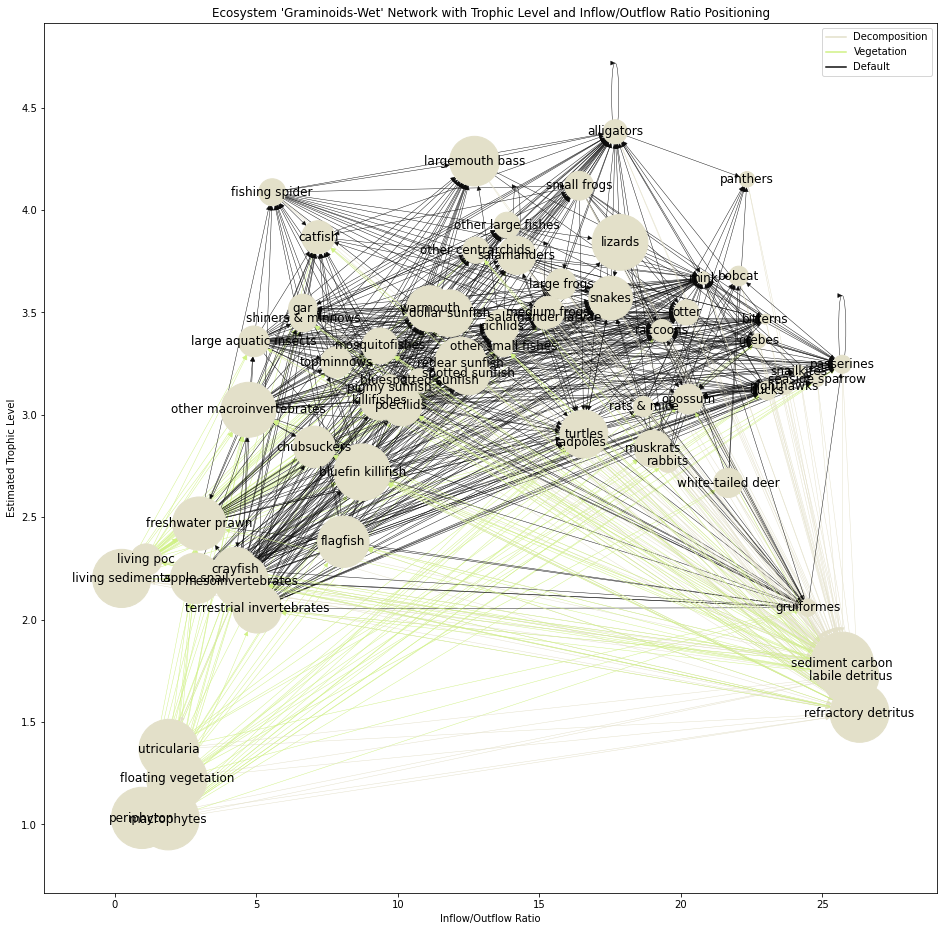

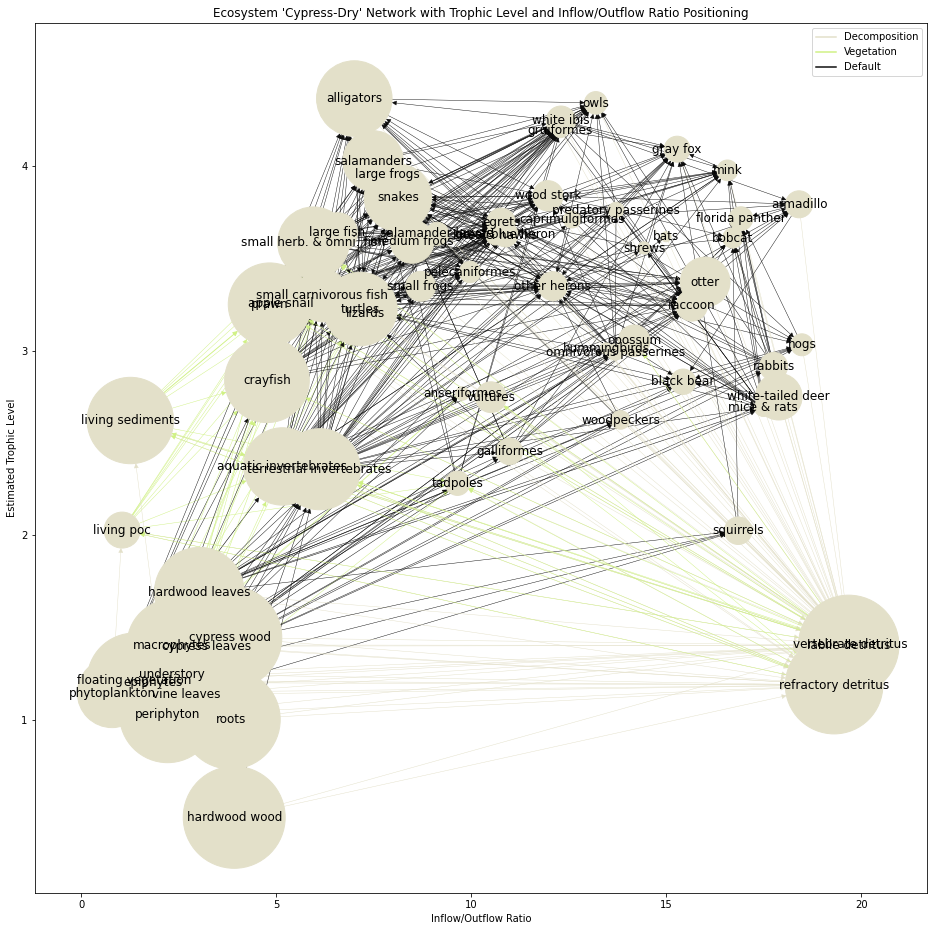

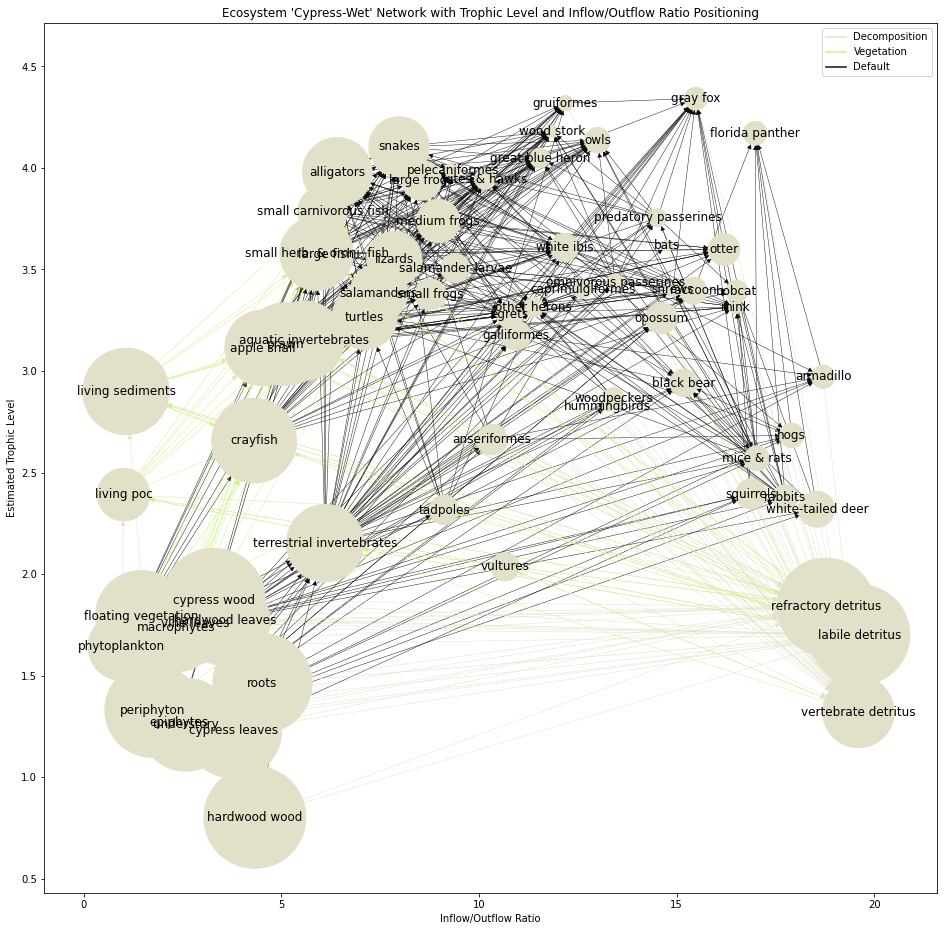

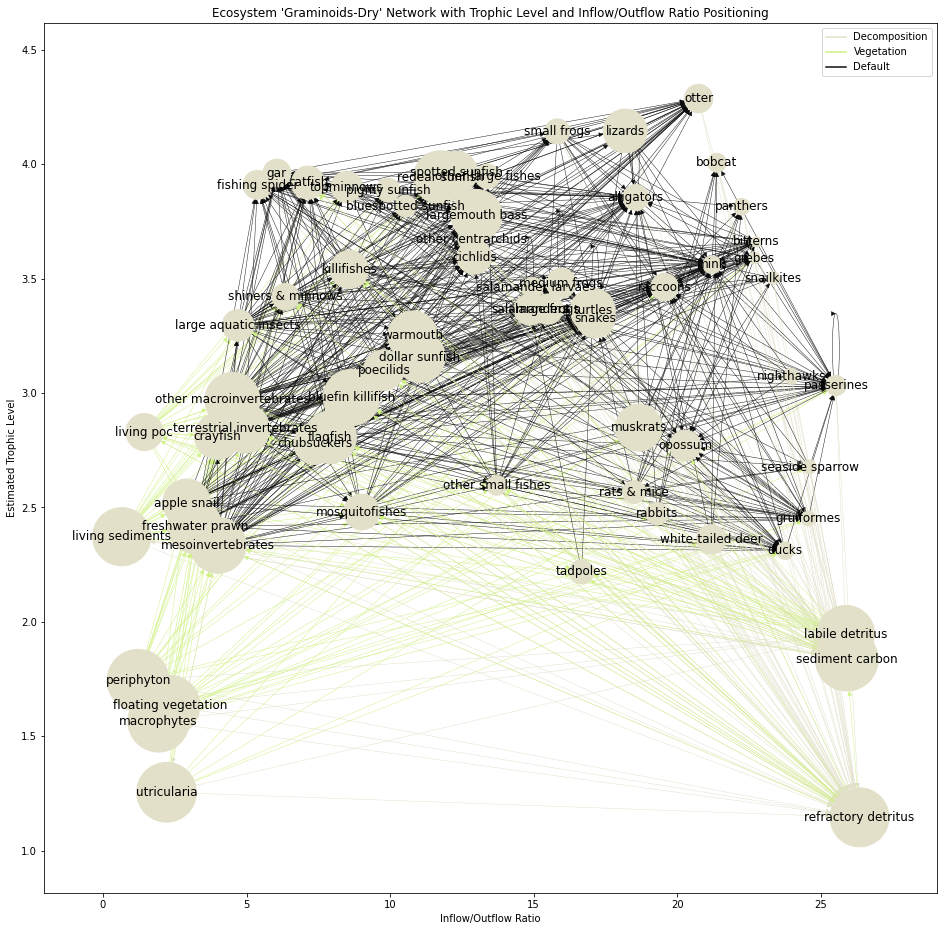

In [1509]:
from matplotlib.lines import Line2D

def hierarchy_pos(G, attr='ETL', lookup=None):
    """
    Computes a hierarchical ordering of nodes in a graph given 
    a node attribute and a lookup table.
    
    Arguments:
      G, networkx graph: graph from which nodes are taken
      attr, str: attribute for each node that will determine x position
      lookup, dict: dictionary that contains a value that will determine y position
      
    Returns:
      pos, dict: dictionary with x,y coordinates of each node
    """
    pos = {}
    pos_existing = np.zeros((1000, 1000))
    for i, node in enumerate(G.nodes()):
        # set x
        if lookup is None:
            x = G.nodes[node].get(attr, 0.0)
        else:
            if lookup.get(node) is None:
                continue
            x = lookup[node]
        # set y
        y = G.nodes[node].get(attr, 0.0)
        jx = np.random.rand()
        jy = np.random.rand()
        pos[node] = (x+jx, y+jy)
        
    return pos


def get_edge_color(edge, colors):
    # string matching criteria for taxa that consume 
    # decaying organic matter, or are vegetation
    kws = [
        'detritus',
        'sediment',
        ' poc',
        'periphyton',
        'utricularia',
        'vegetation',
        'macrophytes']
    
    for kw in kws:
        if kw in edge[1]:
            return colors['color_decay']
        if kw in edge[0]:
            return colors['color_vegetation']
    return colors['color_default']


def plot_graph_hierarchical(key):
    """
    Plots networkx graph given hierarchical ordering, along with some custom
    functionality for node size, edge color, edge weight, and labelling.
    """
    # select graph
    G = g[key]
    
    # remove external world inputs/outputs
    exclude_nodes = ['input', 'output', 'respiration']
    exclude_edges = [(edge) + (None,) for edge in G.edges() \
                     if len(set(exclude_nodes).union(set(edge))) > 0]
    
    # hierarchy positioning
    adj = nx.to_pandas_adjacency(G)
    adj_binary = (adj != 0).astype(int)
    adj_agg = adj_binary.sum(1) / adj_binary.sum(0)
    for node in exclude_nodes:
        del adj_agg[node]
    lookup = dict(zip(
        adj_agg.keys(),
        np.linspace(adj_agg.min(), adj_agg.max(), len(adj_agg))))
    pos = hierarchy_pos(G, attr='ETL', lookup=lookup)
    
    # node/edge selection
    G_res = nx.restricted_view(
        G.copy(),
        exclude_nodes,
        exclude_edges)
    
    # node size
    node_size = np.array([
        G.nodes[node]['biomass'] for node in G.nodes.keys() \
        if not node in exclude_nodes])
    # rescale to bins
    node_bins = np.concatenate([
        np.linspace(100, 1000, len(node_size)//2),
        np.linspace(1000, node_size.max(), len(node_size)//2)])
    # get rank
    node_size_ix = node_size.argsort().argsort()
    node_size = node_bins[node_size_ix]
    
    # edge width
    width = np.array([G.edges[edge+(0,)]['weight'] for edge in G.edges()])
    minmax = lambda x: (x - x.min()) / (x.max() - x.min())
    width = (minmax(width)**2) + 0.45
    
    # edge/node color
    edge_colors = {
        "color_decay": '#e3e0c9', # light gray
        "color_vegetation": '#d0f184', # green
        "color_default": '#0C0C0C', # near black        
    }
    edge_labels = {
        "color_decay": 'Decomposition', 
        "color_vegetation": 'Vegetation', 
        "color_default": 'Default',        
    }
    assert set(edge_colors.keys()).difference(set(edge_labels.keys())) == set() 
    
    edge_color = [get_edge_color(edge, edge_colors) for edge in list(G_res.edges())]
    node_color = '#e3e0c9' # tan
    
    # draw
    fig, ax = plt.subplots(figsize=(16, 16))
    nx.draw(
        G_res,
        pos=pos,
        with_labels=True,
        arrows=True,
        node_color=node_color,
        node_size=node_size,
        width=width,
        edge_color=edge_color,
        ax=ax)
    
    # labels
    ax.set_axis_on()
    ax.set_title(f"Ecosystem '{proper[key]}' Network with Trophic Level and Inflow/Outflow Ratio Positioning")
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax.set_xlabel('Inflow/Outflow Ratio')
    ax.set_ylabel('Estimated Trophic Level')
    
    # legend
    def legend_element(color):
        return Line2D([0, 1], [0, 1], color=color)
    legend_elements = [legend_element(color) for key, color in edge_colors.items()]
    plt.legend(legend_elements, edge_labels.values())
    
    plt.show()
    
for key in g:
    plot_graph_hierarchical(key)

/tmp/ipykernel_19614/4050324605.py:9: RuntimeWarning: divide by zero encountered in log
  ax[0].imshow(np.log(flow))
/tmp/ipykernel_19614/4050324605.py:23: RuntimeWarning: divide by zero encountered in log
  ax[3].imshow(np.log(flow_perturb))


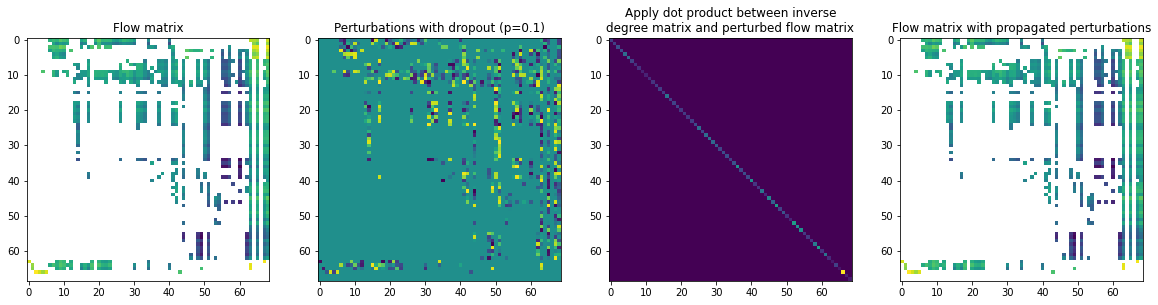

In [1570]:
# Display flow perturbation step-by-step

fig, ax = plt.subplots(1, 4, figsize=(20, 40))

flow = nx.to_numpy_array(G)
adj = (flow != 0).astype(int)

z = np.random.uniform(-0.1, 0.1, flow.shape)
mask = flow.astype(bool) == False
# z_plot = np.ma.masked_array(z, mask)
ax[0].imshow(np.log(flow))
ax[0].set_title("Flow matrix")

p = 0.1
dropout = np.random.choice([0, 1], p=[p, 1-p], size=flow.shape)
z = z * np.array(adj) * dropout + 1
ax[1].imshow(z)
ax[1].set_title(f"Perturbations with dropout (p={p})")

flow_perturb = np.array(flow) * z
flow_perturb = np.dot(degree_inv, flow_perturb) + flow_perturb

ax[2].imshow(degree_inv)
ax[2].set_title("Apply dot product between inverse\ndegree matrix and perturbed flow matrix")
ax[3].imshow(np.log(flow_perturb))
ax[3].set_title("Flow matrix with propagated perturbations")
plt.show()

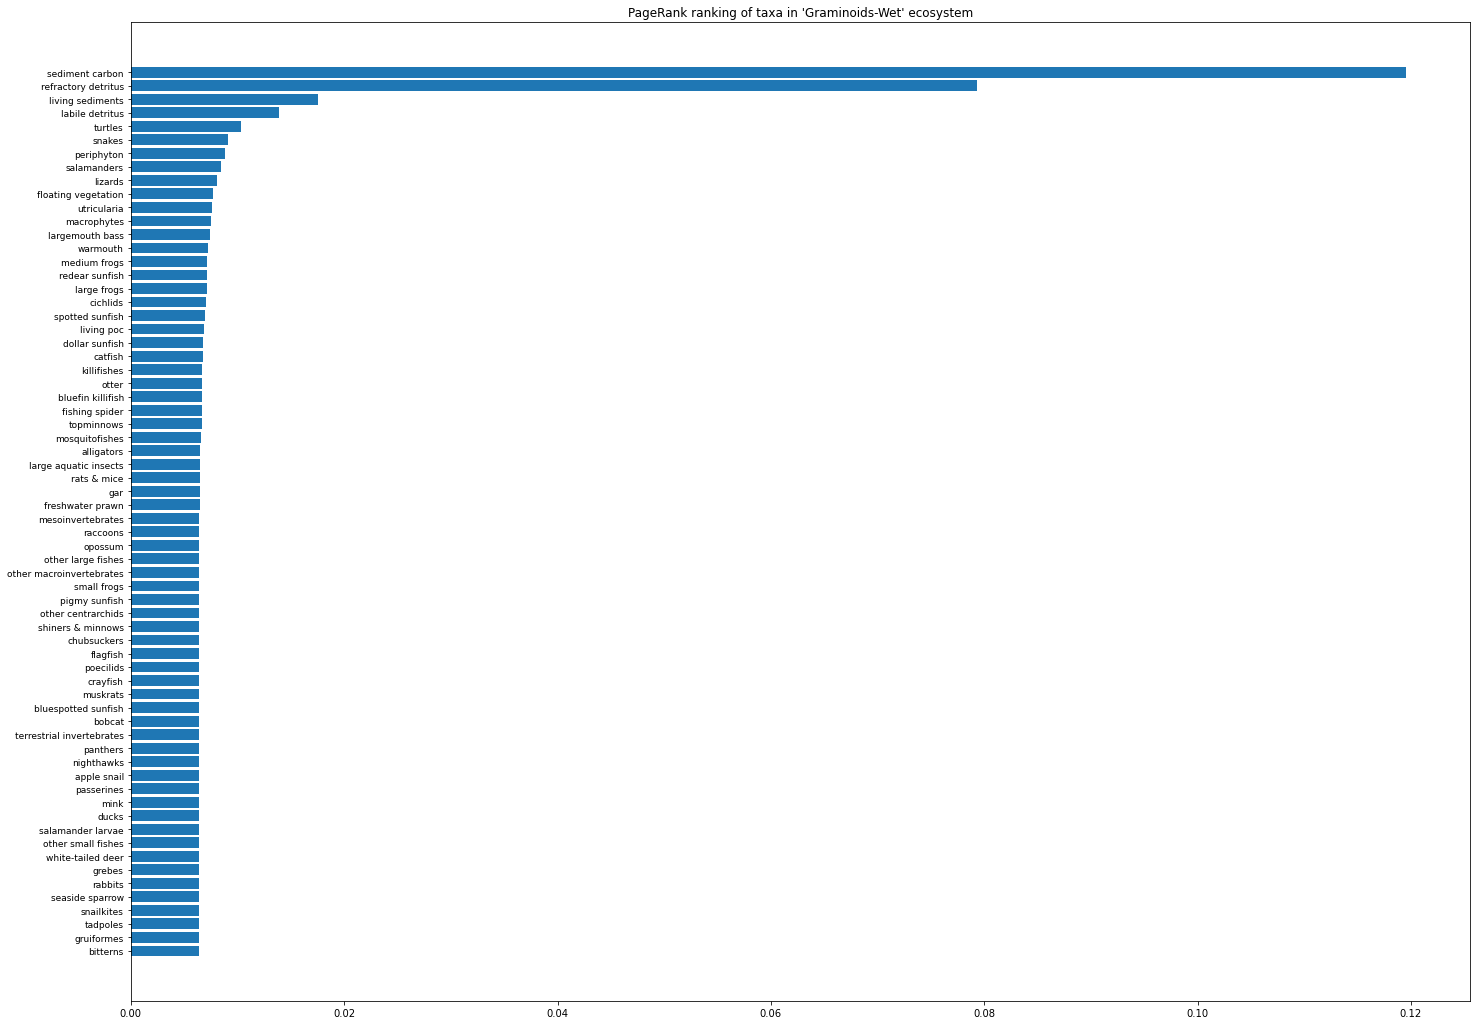

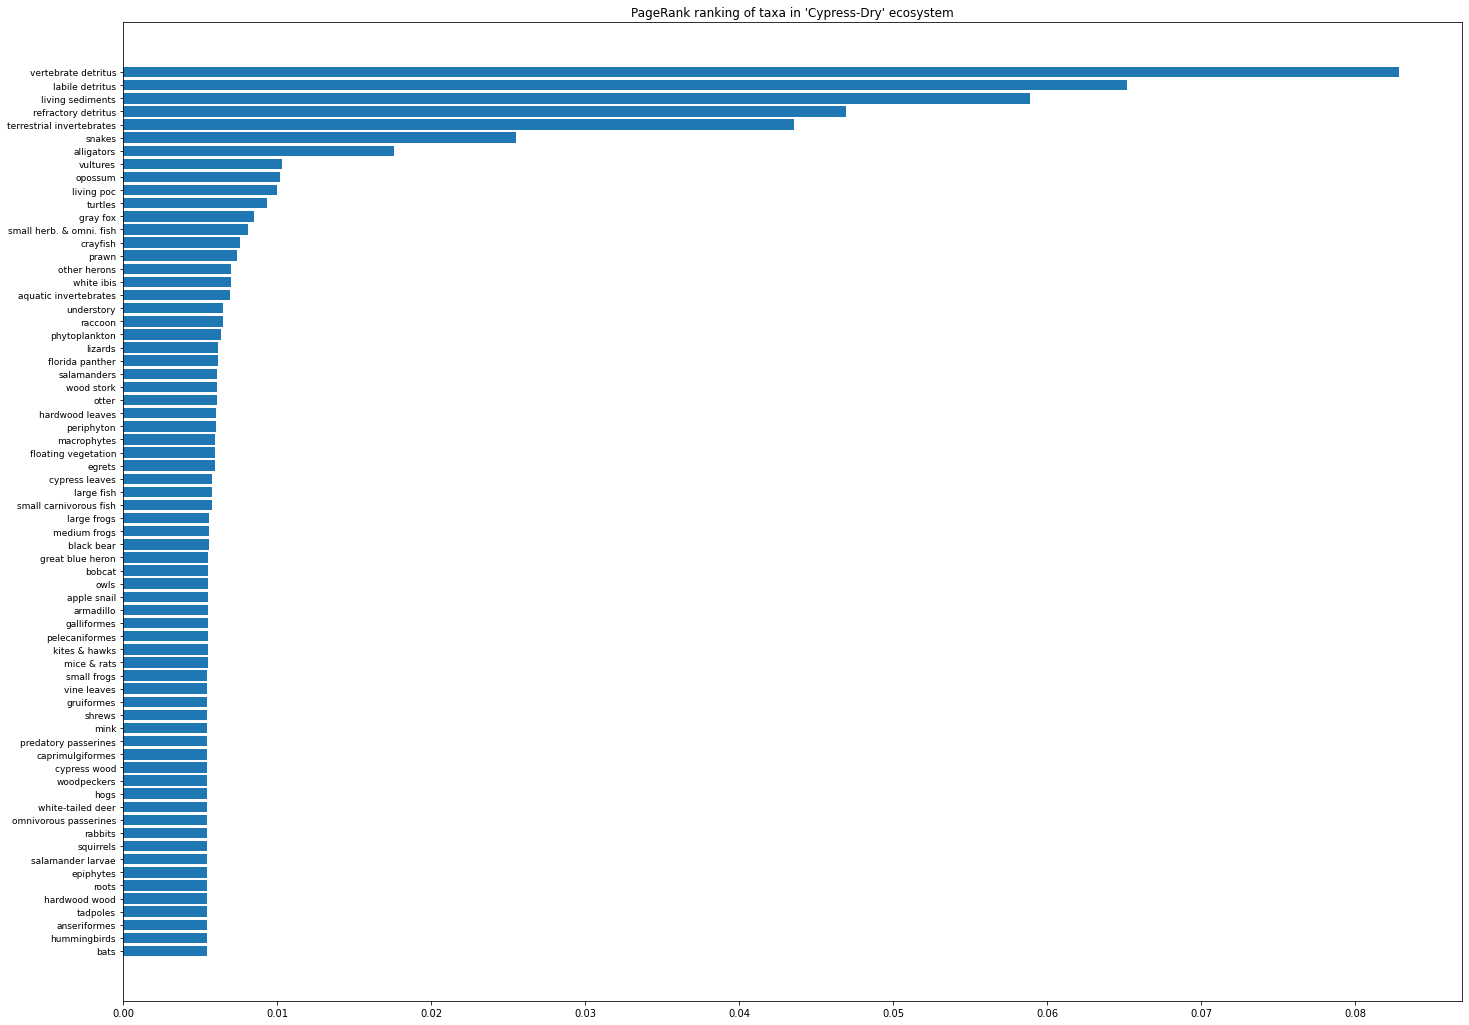

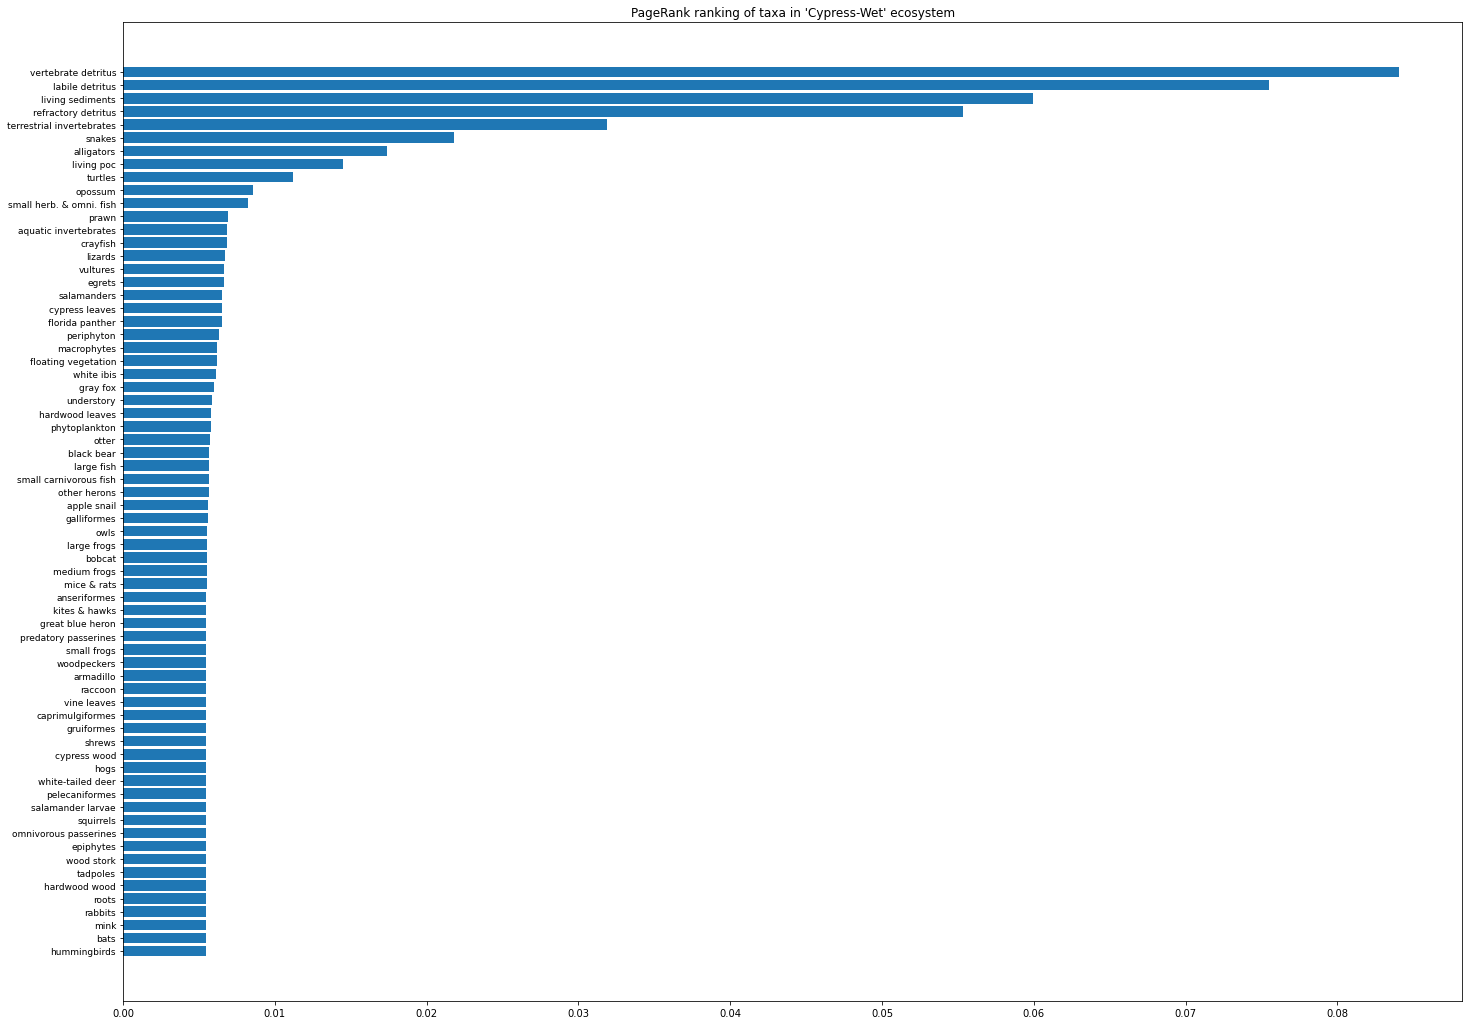

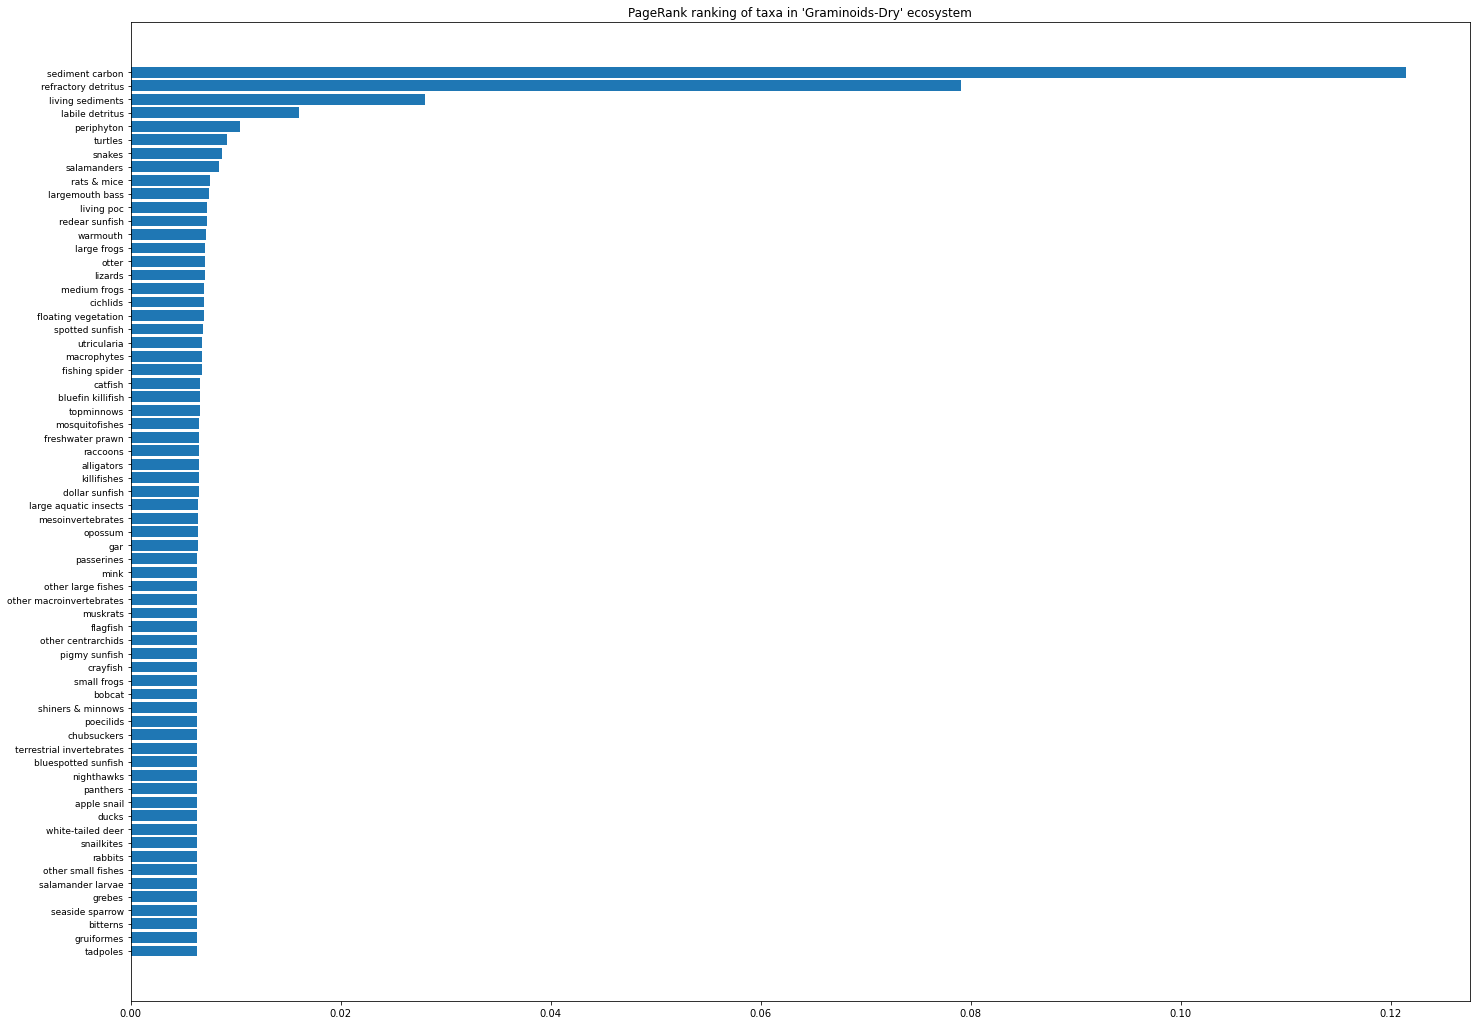

In [1510]:
def plot_pagerank(key):
    """
    Plots PageRank-ordered bar chart of nodes in graph.
    
    Arguments:
      key, str: key for graph dataset.
    """
    G = g[key]
    
    fig, ax = plt.subplots(figsize=(24, 18))

    g_pagerank = sorted(nx.pagerank(G).items(), key=lambda x: x[1])

    xlab = [el[0] for el in g_pagerank if not el[0] in exclude_nodes]
    y = [el[1] for el in g_pagerank if not el[0] in exclude_nodes]
    x = np.arange(len(xlab))

    ax.barh(x, y)
    ax.set_yticks(x)
    ax.set_yticklabels(xlab)
    ax.tick_params(axis='y', which='major', labelsize=9)

    ax.set_title(f"PageRank ranking of taxa in '{proper[key]}' ecosystem")
    plt.show()

for key in g.keys():
    plot_pagerank(key)

In [1319]:
def compute_asc_oh_cap(G, t=None):
    """
    Computes the ascendency, overhead, and capacity of a graph.
    
    Arguments:
      G, networkx graph: graph to perform computation on
      t, numpy array (n, n): custom flow matrix to use instead of flow matrix derived
         from G. Used if computing with a perturbed flow matrix.
    
    Returns:
      (ascendency, capacity, overhead), tuple(float, float float):
      The ascendency, capacity, and overhead computed.
      
    Sources:
    - https://github.com/SEELab/enaR/blob/develop/R/enaAscendency.R
    """
    
    if t is None:
        t = nx.to_pandas_adjacency(G).to_numpy()
    else:
        pass
        
    assert t.shape == nx.to_numpy_matrix(G).shape, f"{t.shape} != {nx.to_numpy_matrix(G).shape}"
            
    tstp = np.sum(t)
    h = t / tstp
    h2 = np.log2(h)
    h2[np.isinf(h2)] = 0
    H = -np.sum(h * h2)
    capacity = H * tstp

    ami = np.empty(t.shape)

    for i in range(ami.shape[0]):
        for j in range(ami.shape[1]):
            if t[i, j] == 0:
                ami[i, j] = 0
            else:
                ami[i, j] = t[i, j] / tstp * np.log2((t[i, j] * tstp) / (np.sum(t[:,j]) * np.sum(t[i,:])))

    avg_mutual_info = np.sum(ami)
    ascendency = tstp * avg_mutual_info
    residual_diversity = H - avg_mutual_info

    oh = np.empty(t.shape)
    for i in range(ami.shape[0]):
        for j in range(ami.shape[1]):
            if t[i, j] == 0:
                oh[i, j] = 0
            else:
                oh[i, j] = t[i, j] * np.log2( (t[i, j]**2) / (np.sum(t[:,j]) * np.sum(t[i,:])) )

    overhead = -np.sum(oh)


    asc_cap = ascendency / capacity
    oh_cap = overhead / capacity
    assert np.isclose(asc_cap + oh_cap, 1)
    
    return ascendency, overhead, capacity

In [1563]:
def pagerank_mask(G, K=5):
    """
    Masks out K nodes in flow matrix, according to NetworkX implementation
    of PageRank.
    
    Arguments:
      G, networkx Graph: graph to rank
      K, int: top k nodes to include in mask, if K < 0, instead of top k,
              this function will return the bottom k (lowest ranking).
    
    Returns:
      mask, numpy array (n, n): mask indicating the rows corresponding to the
            top k or bottom k nodes.
    """
    adj = nx.to_pandas_adjacency(G)
    if abs(K) >= adj.shape[0]:
        return None
    adj_ix = list(adj.index)
    if K < 0:
        K *= -1
        top_k = sorted(nx.pagerank(G).items(), key=lambda x: x[1])[:K]
    else:
        K *= -1
        top_k = sorted(nx.pagerank(G).items(), key=lambda x: x[1])[K:]
    mask = np.zeros(adj.shape)
    for k in top_k:
        k = k[0]
        i = adj_ix.index(k)
        mask[i, :] = 1
            
    return mask

In [1566]:
def perturb_flow(G, bounds=(-0.25, 0.25), p=0.1, mask=None):
    """
    Applies random uniform perturbation. between bounds:
    
    <-- -25% -- | original value | -- +25% -->
    
    Arguments:
      G, networkx Graph: graph to perturb
      bounds, tuple(lower, upper): bounds of perturbance to apply, as
              percentage of original value.
      p, float 0-1: probability of dropout
      mask: custom mask to apply, e.g. masking out top-k nodes.
      
    Returns:
      flow_perturb, numpy array (n, n): perturbed flow matrix
    """
    assert len(bounds) == 2
    
    flow = nx.to_numpy_matrix(G)
    adj = np.array((flow != 0).astype(int))
    if mask is not None:
        adj = adj * mask

    degree = np.array(list(dict(nx.degree(G)).values()))
    degree_inv = np.eye(len(degree)) * (1 / degree)
    
    z = np.random.uniform(*bounds, flow.shape)
    dropout = np.random.choice([0, 1], p=[p, 1-p], size=flow.shape)
    z = z * np.array(adj) * dropout + 1
    flow_perturb = np.array(flow) * z
    
    flow_perturb = np.dot(degree_inv, flow_perturb) + flow_perturb
    
    return flow_perturb

In [1575]:
##################
# Run experiment #
##################

# set parameters
param_dict = {
    "key"           : g.keys(),
    "perturb_bounds": [(-5, 0), (0, 5), (-5, 5), (5, 10), (-5, -10)],
    "pagerank_k"    : [1, 2, 3, -1, -2, -3],
    "perturb_flag"  : [True, False]
}

keys, values = zip(*param_dict.items())
param_set = [dict(zip(keys, v)) for v in itertools.product(*values)]

# iterate over ntrials
ntrials = 50
data = []
for params in param_set:
    G = g[params['key']]
    if params['perturb_flag'] is False:
        niters = 1 # we only need to compute this once
    else:
        niters = ntrials
        
    ascendency = np.zeros(niters)
    overhead = np.zeros(niters)
    capacity = np.zeros(niters)
    asc_cap = np.zeros(niters)
    oh_cap = np.zeros(niters)
    asc_oh = np.zeros(niters)
    
    # perturbations
    for i in range(niters):
        if params['perturb_flag'] is True:
            mask = pagerank_mask(G, K=params['pagerank_k'])
            t = perturb_flow(G, bounds, mask=mask)
        else:
            t = None
            
        # compute ascendancy and other stats
        ascendency[i], overhead[i], capacity[i] = compute_asc_oh_cap(G, t=t)
        asc_cap[i] = ascendency[i] / capacity[i]
        oh_cap[i] = overhead[i] / capacity[i]
        asc_oh[i] = ascendency[i] / overhead[i]
        
    row = params
    row.update({
        "ascendency_mean": ascendency.mean(),
        "ascendency_std": ascendency.std(),
        "capacity_mean": capacity.mean(),
        "capacity_std": capacity.std(),
        "overhead_mean": overhead.mean(),
        "overhead_std": overhead.std(),
        "asc_cap_mean": asc_cap.mean(),
        "asc_cap_std": asc_cap.std(),
        "oh_cap_mean": oh_cap.mean(),
        "oh_cap_std": oh_cap.std(),
        "asc_oh_mean": asc_oh.mean(),
        "asc_oh_std": asc_oh.std(),
        "ntrials": niters,
    })
    
    data.append(row)

/tmp/ipykernel_19614/2015543151.py:12: RuntimeWarning: divide by zero encountered in log2
  h2 = np.log2(h)


In [1577]:
df = pd.DataFrame(data)
df.to_csv("experiment_5.csv")
df

,key,perturb_bounds,pagerank_k,perturb_flag,ascendency_mean,ascendency_std,capacity_mean,capacity_std,overhead_mean,overhead_std,asc_cap_mean,asc_cap_std,oh_cap_mean,oh_cap_std,asc_oh_mean,asc_oh_std,ntrials
0,gramwet,"(-5, 0)",1,True,41544.816612,7.275958e-12,86152.201387,2.910383e-11,44607.384775,1.455192e-11,0.482226,5.551115e-17,0.517774,0.000000,0.931344,1.110223e-16,50
1,gramwet,"(-5, 0)",1,False,38642.809236,0.000000e+00,79572.287423,0.000000e+00,40929.478187,0.000000e+00,0.485631,0.000000e+00,0.514369,0.000000,0.944131,0.000000e+00,1
2,gramwet,"(-5, 0)",2,True,41544.816612,7.275958e-12,86152.201387,2.910383e-11,44607.384775,1.455192e-11,0.482226,5.551115e-17,0.517774,0.000000,0.931344,1.110223e-16,50
3,gramwet,"(-5, 0)",2,False,38642.809236,0.000000e+00,79572.287423,0.000000e+00,40929.478187,0.000000e+00,0.485631,0.000000e+00,0.514369,0.000000,0.944131,0.000000e+00,1
4,gramwet,"(-5, 0)",3,True,56090.766249,5.561849e+03,105359.671428,6.404085e+03,49268.905180,1.510615e+03,0.531161,2.287165e-02,0.468839,0.022872,1.137937,1.028002e-01,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,gramdry,"(-5, -10)",-1,False,20945.283745,0.000000e+00,39853.560185,0.000000e+00,18908.276439,0.000000e+00,0.525556,0.000000e+00,0.474444,0.000000,1.107731,0.000000e+00,1
236,gramdry,"(-5, -10)",-2,True,32483.721184,3.484589e+03,64452.574695,7.340007e+03,31968.853511,4.344428e+03,0.504785,2.204622e-02,0.495215,0.022046,1.023431,9.231884e-02,50
237,gramdry,"(-5, -10)",-2,False,20945.283745,0.000000e+00,39853.560185,0.000000e+00,18908.276439,0.000000e+00,0.525556,0.000000e+00,0.474444,0.000000,1.107731,0.000000e+00,1
238,gramdry,"(-5, -10)",-3,True,32072.357560,3.207901e+03,62942.739383,6.884447e+03,30870.381822,4.138812e+03,0.510443,2.198197e-02,0.489557,0.021982,1.046939,9.536795e-02,50


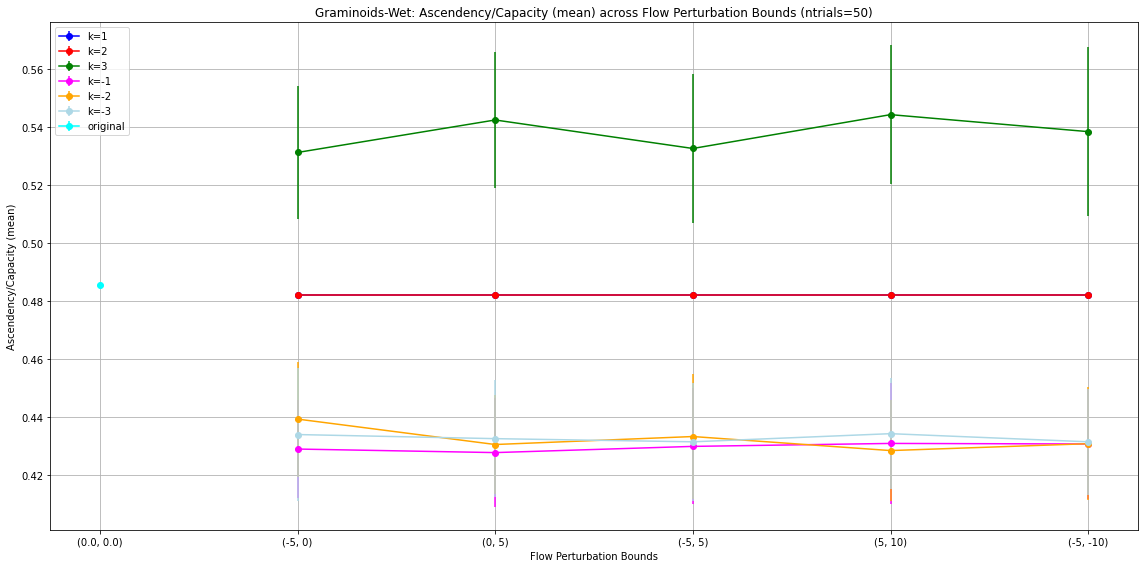

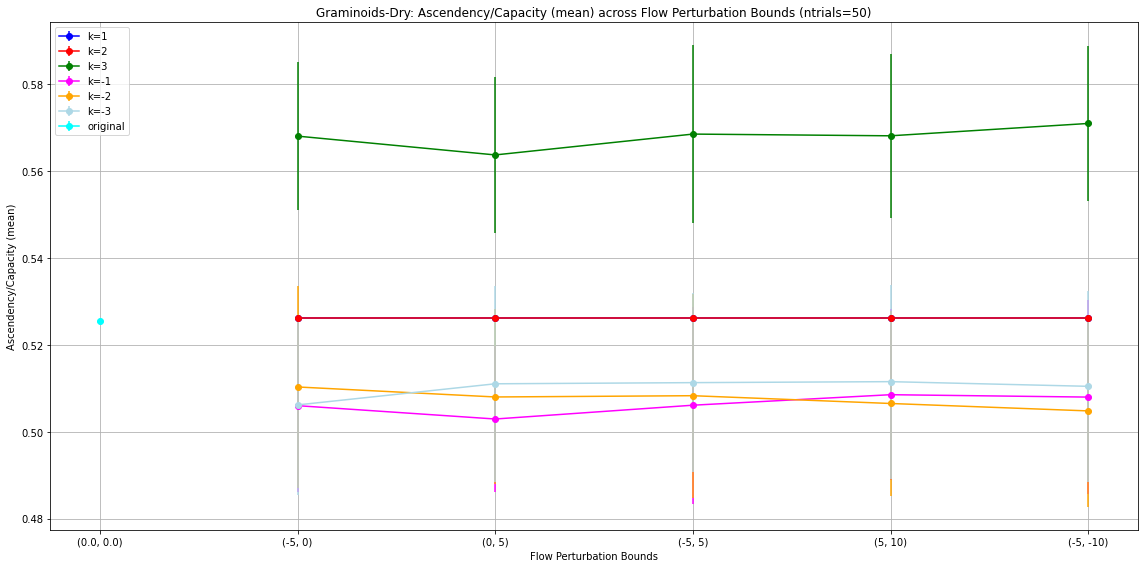

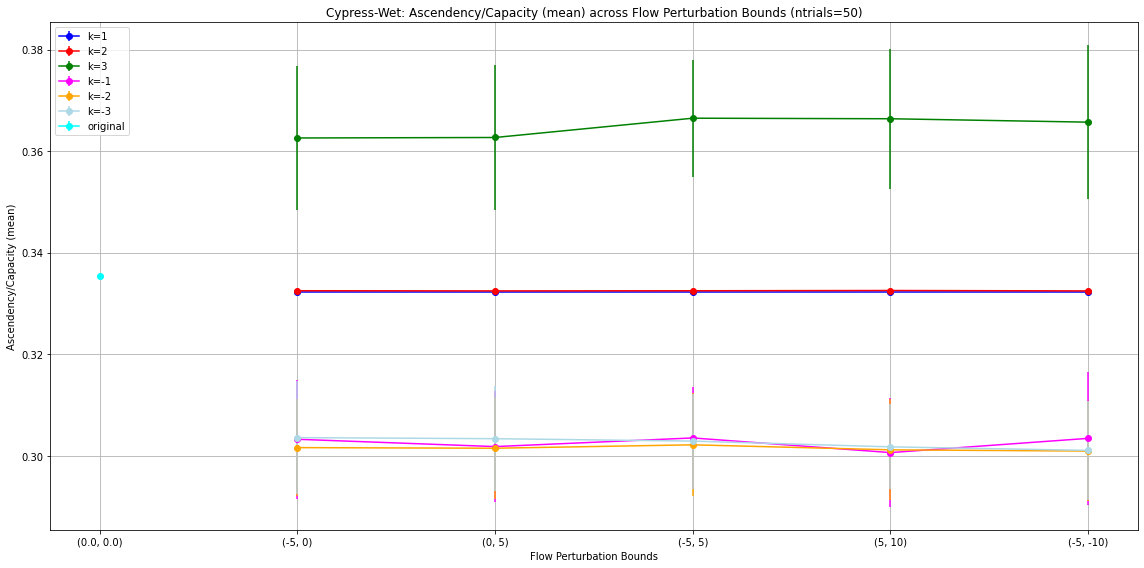

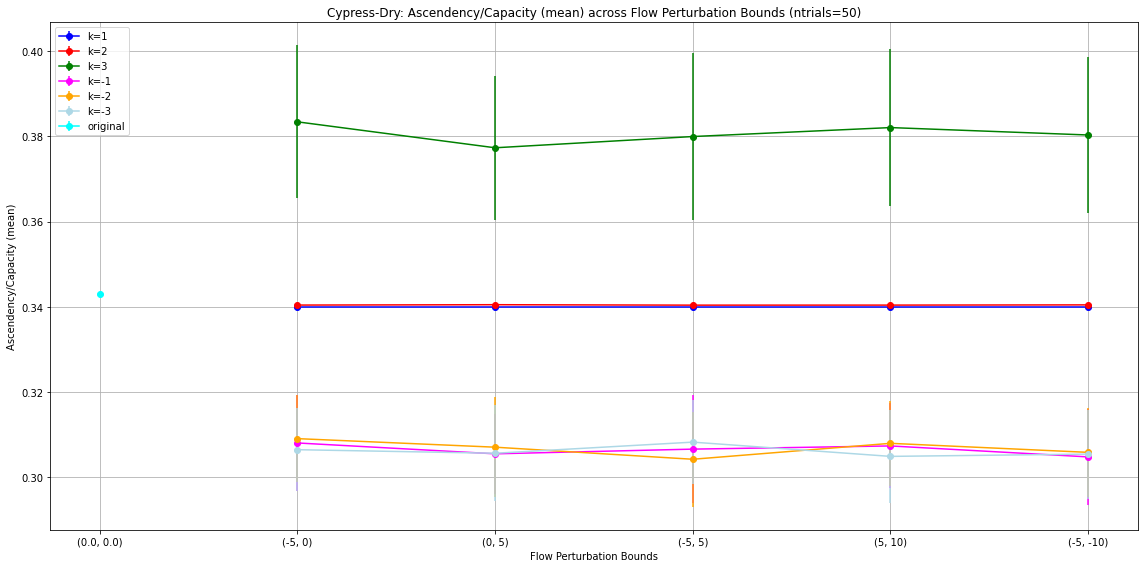

In [1580]:
def plot_experimental_results(key):
    """
    Plots a line graph with error bars, given the experimental dataset compiled.
    """
    yval = 'asc_cap_mean'
    ylab = 'Ascendency/Capacity (mean)'
    yerr = 'asc_cap_std'
    xlab = 'Flow Perturbation Bounds'
    df_sub = df[df['key'] == key]
    fig, ax = plt.subplots(figsize=(16, 8))

    n_perturb_bounds = len(param_dict['perturb_bounds'])
    n_pagerank_k = len(param_dict['pagerank_k'])

    ax.set_xticks(np.arange(n_perturb_bounds+1))
    df_plot = []
    c = ['blue', 'red', 'green', 'magenta', 'orange', 'lightblue', 'pink', 'violet', 'cyan']
    legend = []
    for i in range(n_perturb_bounds):
        for j in range(n_pagerank_k):
            pb = param_dict['perturb_bounds'][i]
            k = param_dict['pagerank_k'][j]
            row = df_sub[
                (df_sub['perturb_bounds'] == pb) &\
                (df_sub['pagerank_k'] == k) &\
                (df_sub['perturb_flag'] == True)]
            assert len(row) == 1
            row = row.reset_index().loc[0]
            y = row[yval]
            row = {
                'x': i+1,
                'y': y,
                'yerr': row[yerr],
                'c':c[j],
                'k': k
            }
            df_plot.append(row)


    row = df_sub[df_sub['perturb_flag'] == False].reset_index().loc[0]
    row = {
        'x': 0.0,
        'y': row[yval],
        'yerr': row[yerr]+1e-6,
        'c':'black',
    }
    df_plot.append(row)
    df_plot = pd.DataFrame(df_plot)
    for i, k in enumerate(df_plot['k'].unique()):
        if np.isnan(k):
            df_plot_k = df_plot[df_plot['k'].isna()]
            k = 'original'
        else:    
            df_plot_k = df_plot[df_plot['k'] == k]
            if k == 100:
                k = 'k=all'
            else:
                k = f"k={int(k)}"
        ax.errorbar('x', 'y', yerr='yerr', data=df_plot_k, fmt='o', c=c[i], linestyle='-', label=k)
    xlabels = [(0.0, 0.0)] + param_dict['perturb_bounds']
    ax.set_xticklabels(xlabels)
    ax.legend()
    ax.grid()
    ax.set_ylabel(ylab)
    ax.set_xlabel(xlab)
    ax.set_title(f"{proper[key]}: {ylab} across {xlab} (ntrials={ntrials})")
    fig.tight_layout()
    plt.show()
    
plot_experimental_results('gramwet')
plot_experimental_results('gramdry')
plot_experimental_results('cypwet')
plot_experimental_results('cypdry')

In [50]:
# scratch

a = np.array([
    [0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0],
    [0, 1, 1, 0, 1, 0, 0],
    [0, 1, 1, 0, 0, 0, 0],
    [1, 0, 0, 1, 0, 0, 0],
    [1, 0, 0, 0, 1, 1, 0]])

In [52]:
a.sum(0) # number of times each organism is a direct food source for another 

array([2, 4, 2, 1, 2, 1, 0])

In [53]:
a.sum(1) # number of direct food sources for each animal

array([1, 0, 1, 3, 2, 2, 3])